# Anomaly Detection Notebook

Let's build this machine learning model using the Isolation Forest Method to find anomalies in the denied transactions

## 1. Import Libraries

In [61]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from datetime import datetime

## 2. Loading Data

In [62]:
data_1 = pd.read_csv('../data/Transactions/transactions_1.csv')

data_1.rename({'f0_':'count'}, axis = 1, inplace=True)

data_1.head()

,time,status,count
0,00h 00,approved,9
1,00h 00,denied,6
2,00h 00,refunded,1
3,00h 01,denied,8
4,00h 01,approved,13


In [63]:
data_2 = pd.read_csv('../data/Transactions/transactions_2.csv')

data_2.head()

,time,status,count
0,00h 00,reversed,7
1,00h 00,approved,9
2,00h 00,processing,12
3,00h 00,denied,3
4,00h 00,backend_reversed,2


## 3. Data Preprocessing

In [64]:
# Convert the 'time' column to datetime format
data_1['time'] = pd.to_datetime(data_1['time'], format='%Hh %M')
data_2['time'] = pd.to_datetime(data_2['time'], format='%Hh %M')

# Create a numeric column for status for machine learning model
data_1['status_num'] = data_1['status'].astype('category').cat.codes
data_2['status_num'] = data_2['status'].astype('category').cat.codes


In [65]:
data_1

,time,status,count,status_num
0,1900-01-01 00:00:00,approved,9,0
1,1900-01-01 00:00:00,denied,6,2
2,1900-01-01 00:00:00,refunded,1,5
3,1900-01-01 00:01:00,denied,8,2
4,1900-01-01 00:01:00,approved,13,0
...,...,...,...,...
4229,1900-01-01 23:59:00,processing,4,4
4230,1900-01-01 23:59:00,denied,1,2
4231,1900-01-01 23:59:00,backend_reversed,5,1
4232,1900-01-01 23:59:00,approved,10,0


In [66]:
data_2

,time,status,count,status_num
0,1900-01-01 00:00:00,reversed,7,6
1,1900-01-01 00:00:00,approved,9,0
2,1900-01-01 00:00:00,processing,12,4
3,1900-01-01 00:00:00,denied,3,2
4,1900-01-01 00:00:00,backend_reversed,2,1
...,...,...,...,...
3939,1900-01-01 23:57:00,denied,11,2
3940,1900-01-01 23:58:00,denied,4,2
3941,1900-01-01 23:58:00,approved,35,0
3942,1900-01-01 23:59:00,denied,10,2


## 4. Data Visualization

Let's visualize all the data and spot the anomalies

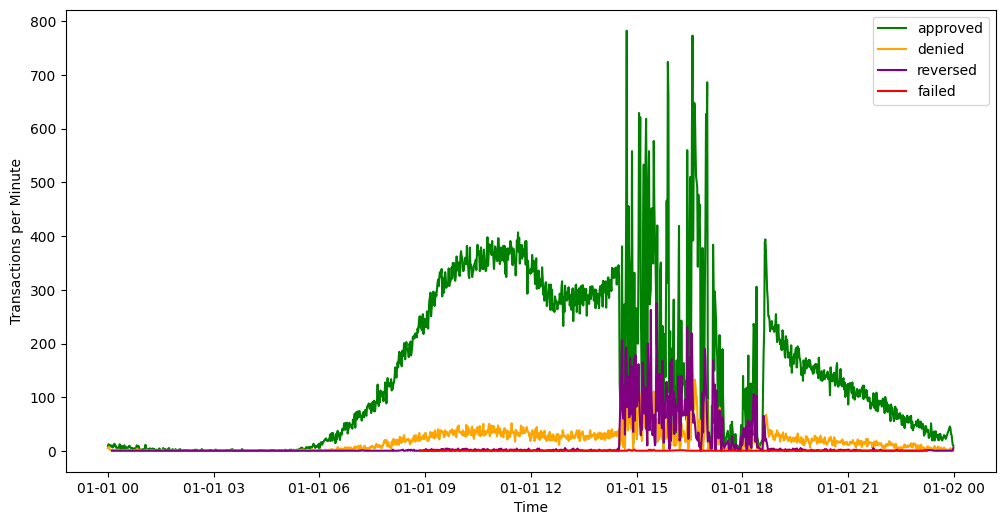

In [67]:
# Defining colors for status
colors = {'approved': 'green', 'denied': 'orange', 'failed': 'red', 'reversed': 'purple'}

# View transaction graph per minute for each status on data 1
plt.figure(figsize=(12, 6))
for status in data_1['status'].unique():
    if status in colors:
        plt.plot(data_1[data_1['status'] == status]['time'], 
                 data_1[data_1['status'] == status]['count'], 
                 label=status, 
                 color=colors[status])

plt.xlabel('Time')
plt.ylabel('Transactions per Minute')
plt.legend()
plt.show()

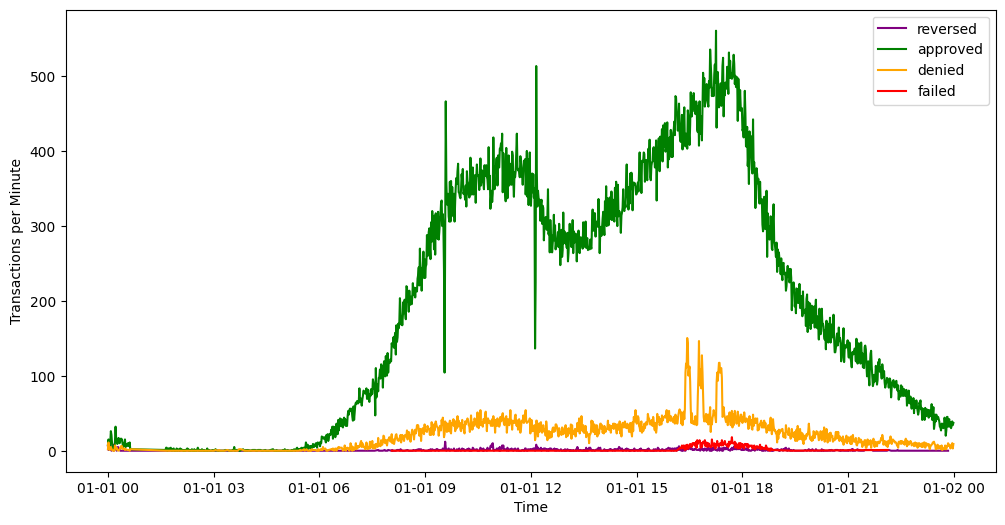

In [68]:
# View transaction graph per minute for each status on data 2
plt.figure(figsize=(12, 6))
for status in data_2['status'].unique():
    if status in colors:
        plt.plot(data_2[data_2['status'] == status]['time'], 
                 data_2[data_2['status'] == status]['count'], 
                 label=status, 
                 color=colors[status])

plt.xlabel('Time')
plt.ylabel('Transactions per Minute')
plt.legend()
plt.show()

We can easy see a point where the anomalies can be found. Lets build a model that detects this behavior

## 5. Building the Anomaly Detection Model

In [69]:
# We can use the dataset 1 to build the model
FEATURES = ['status_num', 'count']

# Train the Isolation Forest model using contamination parameter to spot the anomalies
model = IsolationForest(contamination=0.2, random_state=42) # Adjust as needed
model.fit(data_1[FEATURES])


C:\Users\Pedro Natanael\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.2, random_state=42)

In [70]:
# Create a column with the scores
data_1['anomaly_scores'] = model.decision_function(data_1[FEATURES])
data_2['anomaly_scores'] = model.decision_function(data_2[FEATURES])

In [71]:
# Create a column to evaluate the score
data_1['anomaly'] = model.predict(data_1[FEATURES])
data_2['anomaly'] = model.predict(data_2[FEATURES])

In [72]:
# Counting the number of anomalies the model found in all transactions per minute
data_1[data_1['anomaly'] == -1].groupby("status")['count'].agg("count").reset_index()

,status,count
0,approved,403
1,backend_reversed,34
2,denied,67
3,failed,53
4,processing,56
5,refunded,38
6,reversed,196


In [73]:
# Counting the number of anomalies the model found in all transactions per minute
data_2[data_2['anomaly'] == -1].groupby("status")['count'].agg("count").reset_index()

,status,count
0,approved,584
1,backend_reversed,5
2,denied,34
3,failed,167
4,processing,1
5,refunded,1
6,reversed,17


This model found many anomalies in others indicators, but we are interested only in "denied" transactions, wich we will see in the graphic bellow

## 6. View Anomalies

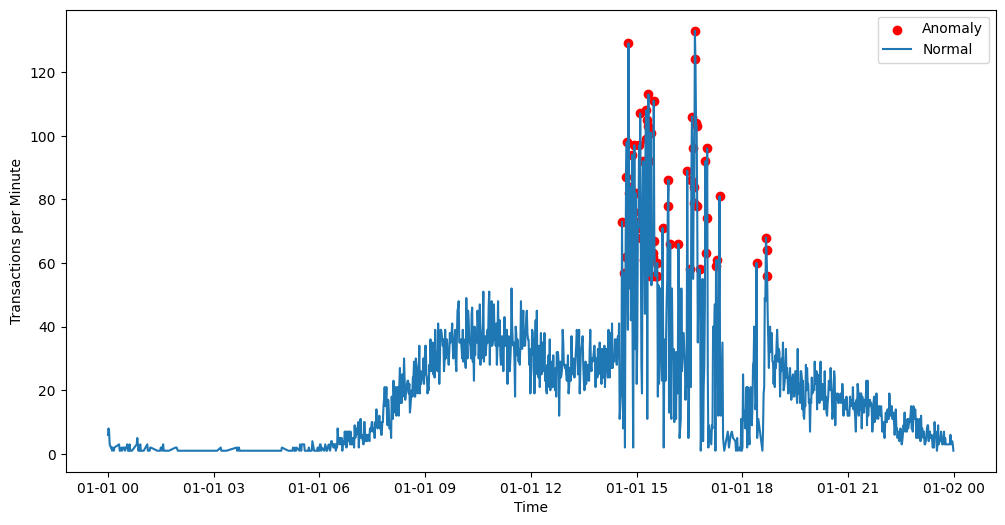

In [74]:
# View anomalies in denied transactions 1
plt.figure(figsize=(12, 6))
plt.scatter(data_1[(data_1['anomaly'] == -1) & (data_1['status'] == 'denied')]['time'], data_1[(data_1['anomaly'] == -1) & (data_1['status'] == 'denied')]['count'], color='red', label= 'Anomaly')
plt.plot(data_1[data_1['status'] == 'denied']['time'], data_1[data_1['status'] == 'denied']['count'], label='Normal')

plt.xlabel('Time')
plt.ylabel('Transactions per Minute')
plt.legend()
plt.show()

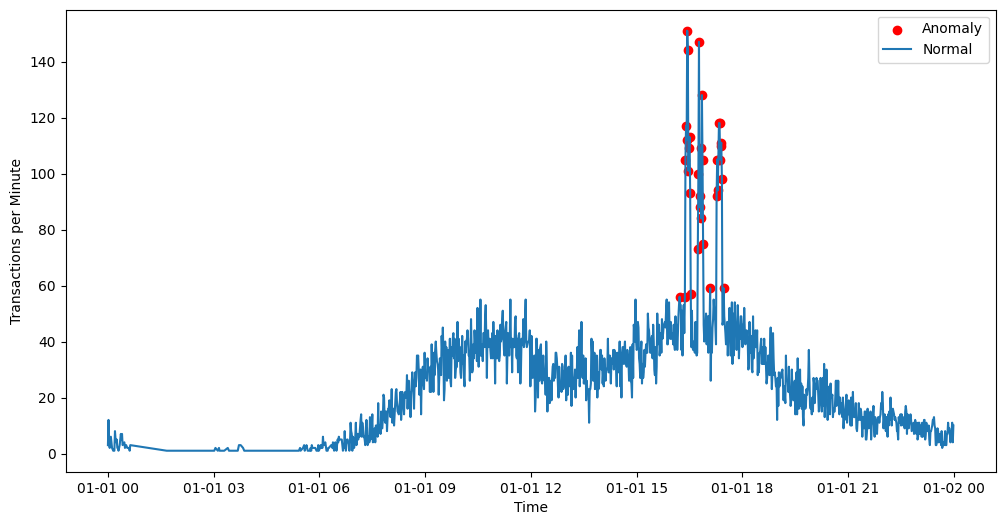

In [75]:
# View anomalies in denied transactions 2
plt.figure(figsize=(12, 6))
plt.scatter(data_2[(data_2['anomaly'] == -1) & (data_2['status'] == 'denied')]['time'], data_2[(data_2['anomaly'] == -1) & (data_2['status'] == 'denied')]['count'], color='red', label= 'Anomaly')
plt.plot(data_2[data_2['status'] == 'denied']['time'], data_2[data_2['status'] == 'denied']['count'], label='Normal')

plt.xlabel('Time')
plt.ylabel('Transactions per Minute')
plt.legend()
plt.show()

In [77]:
data_1[(data_1['anomaly'] == -1) & (data_1['status'] == 'denied') & (data_1['anomaly_scores'] < 0)]

,time,status,count,status_num,anomaly_scores,anomaly
2105,1900-01-01 14:35:00,denied,73,2,-0.037396,-1
2123,1900-01-01 14:38:00,denied,57,2,-0.002436,-1
2137,1900-01-01 14:41:00,denied,62,2,-0.026469,-1
2141,1900-01-01 14:42:00,denied,87,2,-0.064774,-1
2149,1900-01-01 14:43:00,denied,98,2,-0.073673,-1
...,...,...,...,...,...,...
2999,1900-01-01 17:21:00,denied,81,2,-0.058217,-1
3246,1900-01-01 18:24:00,denied,60,2,-0.019509,-1
3289,1900-01-01 18:40:00,denied,68,2,-0.035002,-1
3292,1900-01-01 18:41:00,denied,64,2,-0.029658,-1


In [78]:
data_2[(data_2['anomaly'] == -1) & (data_2['status'] == 'denied') & (data_2['anomaly_scores'] < 0)]

,time,status,count,status_num,anomaly_scores,anomaly
2403,1900-01-01 16:13:00,denied,56,2,-0.000796,-1
2443,1900-01-01 16:22:00,denied,56,2,-0.000796,-1
2447,1900-01-01 16:23:00,denied,105,2,-0.080138,-1
2454,1900-01-01 16:24:00,denied,117,2,-0.088211,-1
2459,1900-01-01 16:25:00,denied,112,2,-0.087651,-1
2464,1900-01-01 16:26:00,denied,151,2,-0.097800,-1
2468,1900-01-01 16:27:00,denied,144,2,-0.099999,-1
2474,1900-01-01 16:28:00,denied,101,2,-0.075430,-1
2477,1900-01-01 16:29:00,denied,109,2,-0.083045,-1
2484,1900-01-01 16:30:00,denied,113,2,-0.088490,-1


As we can see, the model correctly predicted 74 points where there is anomalies in the process. Let's use this model to implement the API

In [79]:
with open('../models/IF_model.pkl','wb') as file_model:
    pickle.dump(model, file_model)